Description: Datasets modification framework using cluster analysis

Author: Jiří Setinský

Date: 2.5. 2023

Contact: xsetin00@stud.fit.vutbr.cz



# Dependencies



In [48]:

#!pip install h2o 
#!pip install joblib -U

#!pip install yellowbrick

import pandas as pd
import numpy as np
import sys
import h2o
from h2o.estimators import H2OKMeansEstimator
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('default')
import math
import itertools
from abc import ABC, abstractmethod
import sklearn.metrics as metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans,MeanShift,AgglomerativeClustering, MiniBatchKMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from joblib import dump, load
from joblib import Parallel, delayed
from imblearn.under_sampling import RandomUnderSampler,CondensedNearestNeighbour, NearMiss, EditedNearestNeighbours,RepeatedEditedNearestNeighbours,InstanceHardnessThreshold,NeighbourhoodCleaningRule,TomekLinks,ClusterCentroids,OneSidedSelection,AllKNN
from yellowbrick.cluster import KElbowVisualizer

In [49]:
import os
os.environ['JAVA_HOME'] = '/home/netmon/xsetin00/jdk-17'
os.environ['PATH'] = '/home/netmon/xsetin00/jdk-17/bin:' + os.environ['PATH']

print(os.environ['PATH'])

/home/netmon/xsetin00/jdk-17/bin:/home/netmon/xsetin00/jdk-17/bin:/home/netmon/xsetin00/jdk-17/bin:/home/netmon/xsetin00/jdk-17/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin


# Class definitions

## Dataset class

In [50]:
class Dataset():
  
  def __init__(self, path, label, use_case, class_values,to_drop=[]):
    self.path = path
    self.label = label
    self.use_case = use_case
    self.pos_value=class_values[0]
    self.neg_value=class_values[1]
    to_drop.append(label)
    self.to_drop=to_drop
    self.total_acc={}
  
  # Rename class values
  def new_classes(self,label):
    if label == self.pos_value:
        return 1
    else:
        return 0

  # Load data
  def load(self):
    self.csv_data=pd.read_csv(self.path)
    self.csv_data[self.label]=self.csv_data[self.label].apply(self.new_classes)
    return self.csv_data
  
  # Set internal data
  def set_data(self,data):
    self.csv_data=data
  
  # Get label data for current class
  def get_label(self,data=None):
    if data is None:
      return self.csv_data[self.label][self.csv_data[self.label]==self.flag].reset_index(drop=True)
    return data[self.label][data[self.label]==self.flag].reset_index(drop=True)

  # Get features data for current class
  def get_features(self,data=None):
    if data is None:
      return self.csv_data[self.csv_data[self.label]==self.flag].drop(columns=self.to_drop,errors="ignore").reset_index(drop=True)
    return data[data[self.label]==self.flag].drop(columns=self.to_drop,errors="ignore").reset_index(drop=True)
  
  # Get label data for all classes
  def get_all_label(self):
    return self.csv_data[self.label].reset_index(drop=True)

  # Get features data for all classes
  def get_all_features(self):
    return self.csv_data.drop(columns=self.to_drop,errors="ignore").reset_index(drop=True)

  # Set context to current class
  def set_class(self,flag):
    self.flag=flag
    self.y=self.get_label()
    self.X=self.get_features()
  
  # Get class balance
  def class_balance(self,data=None):
    if data is None:
      data=self.get_all_label()
    pos=data[data==1].shape[0]
    neg=data.shape[0]-pos
    return {0:neg,1:pos,'all':data.shape[0]}

  # Correlation with class
  def get_corr_analysis(self):
    correlation_with_class=self.csv_data.drop(columns=[self.label]).corrwith(self.csv_data[self.label],method='spearman').reset_index()
    #print(correlation_with_class)
    correlation_with_class.columns=["atrr","corr"]
    
    corr_pos=correlation_with_class[correlation_with_class["corr"] >= 0.3]
    corr_neg=correlation_with_class[correlation_with_class["corr"] <= -0.3]

    self.class_corr=pd.concat([corr_pos,corr_neg],axis=0).reset_index(drop=True)
    #class_corr.to_csv('/content/drive/My Drive/Cluster/correlation_dga.txt',header=False)
    #self.class_corr=pd.read_csv('xsetin00/correlation_dga.txt',header=None,names=["atrr","corr"])##
    return self.class_corr
    
  # Get correlation pairs with opposite coefficient
  def get_corr_pairs(self):
    #self.class_corr=pd.read_csv('/content/drive/My Drive/Cluster/correlation_dga.txt',header=None,names=["atrr","corr"])
    pos_corr=list(self.class_corr[self.class_corr["corr"]>0]["atrr"])
    neg_corr=list(self.class_corr[self.class_corr["corr"]<0]["atrr"])

    self.corr_pairs=list(itertools.product(pos_corr,neg_corr))+list(itertools.product(neg_corr,pos_corr))
    return self.corr_pairs
  
  # Classify only one class with given model
  def dataset_acc(self,clf,label):
    self.set_class(label)
    pred=clf.predict(self.X)
    ######print(classification_report(self.data.y,pred))#Data["is_doh"], pred))
    self.total_acc[label]=metrics.accuracy_score(self.y,pred)
    ######metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(self.data.y, pred) ).plot();
    #return self.total_acc
    return f"Accuracy for class {label} is {self.total_acc[label]}"
    
  # Save data to csv
  def save(self,path):
      self.csv_data.to_csv(path,index=False)  

## Modifier class

In [51]:
class Modifier(Dataset):

    def __init__(self,new_path,label,use_case,class_values,to_drop=[]):
        super().__init__(new_path,label,use_case,class_values,to_drop)
        self.newdata=pd.DataFrame()
        self.improvement=0

    # Update csv data with new data 
    def update_csv(self):
        self.csv_data=self.newdata
        self.newdata=pd.DataFrame()

    # Set new data  
    def set_newdata(self,X=pd.DataFrame(),y=pd.DataFrame()):
        self.newdata=pd.concat([X,y],axis=1)

    # Save new data to csv
    def save_new(self,path):
      self.newdata.to_csv(path,index=False)

    # Extract demanded data from each cluster based on weight vector
    def extract(self,cluster_model,reduced_amount,oversample=True):
        self.set_class(cluster_model.class_number)
        cluster_model.data.set_class(cluster_model.class_number)
        cluster_model.predict(self)
        self.get_data_amount(cluster_model,reduced_amount,oversample)
        print("POTENTIAL AMOUNT",self.potential_amount)
        print("REDUCED AMOUNT",reduced_amount)
        aug_weight=min(reduced_amount/self.potential_amount,1)
        new_data_sampled=pd.DataFrame()
        for aug_can,coeff in cluster_model.coeffs.items():
            data_to_sample=cluster_model.result_new[cluster_model.result_new["predict"]==aug_can]
            
            data_to_sample=data_to_sample.sample(frac=min(coeff*self.weight,1)*aug_weight,random_state= np.random.RandomState())#ranmagic,random_state=42)
            
            new_data_sampled=pd.concat([new_data_sampled,data_to_sample])

        new_data_sampled=new_data_sampled.join(self.X)
        new_data_sampled=new_data_sampled.join(self.y)
        new_data_sampled.pop("predict")
        print("Extracted data",cluster_model.class_number," - ",new_data_sampled.shape[0])
        #self.newdata=pd.concat([self.newdata,new_data_sampled])
        return new_data_sampled

    # Find potential amount of data to extract 
    def get_data_amount(self,model,total_demand,oversample):
        self.potential_amount=0
        clusters,counts=np.unique(model.result_new,return_counts=True)

        for cluster,amount in zip(clusters,counts):
            self.potential_amount+=model.coeffs[cluster]*amount

        self.potential_amount=int(self.potential_amount)
        reduce_ratio=total_demand/self.potential_amount
        if reduce_ratio > 1 and oversample:
            self.weight=reduce_ratio*1.11
            self.potential_amount=int(sum([(min(model.coeffs[cluster]*self.weight,1))*amount for cluster,amount in zip(clusters,counts)]))
        else:
            self.weight=1

    # Plot class balance
    def plot_balance(self,title,data=None):
        if data is None:
            data=self.get_all_label()
        ax=data.value_counts().plot.pie(title=f"{title}\n\n"+"{:,}".format(data.shape[0]),autopct='%1.1f%%')
        fig=ax.get_figure()
        #fig.savefig(f"xsetin00/{self.use_case}/{title}.png",dpi=500)
        plt.show()

    # Plot classification report
    def plot_report(self,report,title):

        ax=sns.heatmap(report.iloc[:-1, :].T, annot=True,fmt='.4f')
        #total_acc=metrics.accuracy_score(y,pred)
        plt.yticks(rotation=0)
        plt.title(title) 
        #report.transpose().to_latex(f"xsetin00/{self.use_case}/{title} report.tex",float_format="{:.4f}".format,caption=title,label=f"tab:{title}")
        #ax.get_figure().savefig(f"xsetin00/{self.use_case}/{title} report.png",dpi=500)
        plt.show()

    # Compare model on old data between model on clustered data
    def compare_models(self,old,new,test_data,compared_model="Clustered"):

        X_train=self.newdata.drop(columns=self.label).reset_index(drop=True)
        y_train=self.newdata[self.label].reset_index(drop=True)
        new.fit(X_train,y_train)

        cnt_old=self.class_balance(self.get_all_label())
        print("Old dataset balance",cnt_old)
        self.plot_balance("Old dataset balance",self.get_all_label())

        self.cnt_new=self.class_balance(y_train)
        print(f"{compared_model} dataset balance",self.cnt_new)
        self.plot_balance(f"{compared_model} dataset balance",y_train)


        print("Reduction ratio",100-self.cnt_new['all']/cnt_old['all']*100)
        X=test_data.get_all_features()
        y=test_data.get_all_label()

        pred_old = old.predict(X)
        report_old=pd.DataFrame(classification_report(y,pred_old,digits=4,output_dict=True))
        self.plot_report(report_old,"Old model")
        self.plot_matrix(y,pred_old,"Old model CM")


        pred_new = new.predict(X)
        report_new=pd.DataFrame(classification_report(y,pred_new,digits=4,output_dict=True))
        self.plot_report(report_new,f"{compared_model} model")
        self.plot_matrix(y,pred_old,f"{compared_model} model CM")


        f1_old=metrics.f1_score(y,pred_old,average="weighted")
        f1_new=metrics.f1_score(y,pred_new,average="weighted")
        #print(f1_old,f1_new)
        space_to_improve=1-f1_old
        self.improvement=(f1_new-f1_old)/space_to_improve*100
        print("Improvement",self.improvement)

        return classification_report(y,pred_new,digits=4,output_dict=True)

    # Apply existing methods for data modification 
    def apply_imbalanced_lib(self,sampler,prep=False):
        X_old=self.get_all_features()
        y_old=self.get_all_label()
        if prep:
            pipe=make_pipeline(StandardScaler(),VarianceThreshold())
            X_res, y_res = sampler.fit_resample(pipe.fit_transform(X_old), y_old)
            X_res=pipe.inverse_transform(X_res)
            X_res=pd.DataFrame(X_res, columns = X_old.columns)
        else:
            X_res, y_res = sampler.fit_resample(X_old, y_old)
            
        self.set_newdata(X_res, y_res)

    # Model results to export
    def prepare_model_result(self,report,method,dataset,metric='default'):
        #Methods OA Precision Recall F measure
        return pd.DataFrame({'Dataset':dataset, 'Method':method,'Metric':metric, 'Acc':report['accuracy'], 'Precision':report['weighted avg']['precision'], 'Recall':report['weighted avg']['recall'], 'F1':report['weighted avg']['f1-score'],"Impr":self.improvement,"Support_0":str(self.cnt_new[0]),"Support_1":str(self.cnt_new[1])},index=[0])

    # Plot confusion matrix
    def plot_matrix(self,y,pred,title):
        matrix=metrics.ConfusionMatrixDisplay( metrics.confusion_matrix(y, pred) )
        matrix.plot()
        plt.show()
        # fig=matrix.figure_
        # fig.set_figwidth(8)
        # fig.set_figheight(8)  
        # fig.savefig(f"xsetin00/{self.use_case}/{title}.png",dpi=500)


## Cluster class

In [63]:
class Cluster():
  
  def __init__(self):
    self.data = []
    self.report = {}
  
  # Append row to cluster
  def add_data(self, row):
    self.data.append(row)

  # Convert data to numpy array
  def data_to_array(self,columns):
    self.collumns=np.array(columns)
    self.array = np.array(self.data)

  # Get accuracy of cluster 
  def classify_cluster(self, classifier, label):
    pred = classifier.predict(pd.DataFrame(self.array, columns=self.collumns))
    y_gen = np.repeat(label, self.array.shape[0])
    self.report["acc"] = metrics.accuracy_score(y_gen, pred)

  # Variance of cluster's features
  def variance(self):
    self.report["var"] = np.var(self.array, axis=0)

  # Mean of cluster's features
  def get_mean(self):
    self.mean = np.mean(self.array, axis=0)
    self.report["mean"] = self.mean

  # Deviation of cluster's features
  def diff(self, original_mean, min_val, max_val):
    # average deviation of features
    diff = self.mean - original_mean
    # get maximal difference
    lower_min = np.abs(original_mean - min_val)
    lower_max = np.abs(original_mean - max_val)

    diff_result = np.zeros_like(diff)

    for i, value in enumerate(diff):
        if value == 0:
            diff_result[i] = 0
        else:
            if value < 0:
                diff_result[i] = value / lower_min[i]
            else:
                diff_result[i] = value / lower_max[i]

    self.report["dev"] = diff_result
    #print("DEVIATION",self.report['dev'])

  # Correlation of cluster's features
  def correlation(self):
    pairs_to_drop = set()
    dataframe=pd.DataFrame(self.array,columns=self.collumns)
    cols = dataframe.columns
    for i in range(0, dataframe.shape[1]):
      for j in range(0, i+1):
        pairs_to_drop.add((cols[i], cols[j]))
    out=dataframe.corr(method='spearman').unstack().drop(labels=pairs_to_drop).sort_values().dropna()
    ######print(out.to_string())
    self.report["corr"]=out
    #self.report["corr"] = np.corrcoef(self.array.)
    #print("CORRELATION",self.report['corr'])

  # Size of cluster
  def size(self):
    self.report["size"] = self.array.shape[0]

  # Relative size of cluster
  def inv_amount(self, original_size):
    self.amount_ratio = self.report["size"] / original_size
    self.inv_amount_ratio = 1 - self.amount_ratio

  # Average deviation of cluster's features
  def diff_deviation(self):
    self.extreme_deviation = self.report["dev"][np.logical_or(self.report["dev"] < -50, self.report["dev"] > 50)]
    self.mean_deviation = np.mean(np.abs(self.report["dev"]))

    extreme_deviation_cnt = len(self.extreme_deviation)
    self.ratio_extreme_deviation = extreme_deviation_cnt / len(self.report["dev"])

  # Adversial distance of cluster's features
  def adversial(self, data):
    #corr_pos = self.report["corr"][self.report["corr"] >= 0.75]
    corr_neg = self.report["corr"][self.report["corr"] <= -0.3]
    self.adversial_distance = 0
    corr_cnt = 0

    if corr_neg.shape[0] != 0:
        for i in range(corr_neg.shape[0]):
            corr = corr_neg[i]
            if corr in data.corr_pairs:
                corr_cnt += 1
                first = corr[0]
                second = corr[1]
                self.adversial_distance += np.abs(self.report["dev"][np.where(self.collumns==first)] - self.report["dev"][np.where(self.collumns==second)])
        if corr_cnt != 0:
            self.adversial_distance /= corr_cnt * 2
            self.adversial_distance = 1 - self.adversial_distance
  
  # Similarity of cluster's features to another class           
  def similarity(self,data):
    neg_attr=list(data.class_corr[data.class_corr["corr"]<0]["atrr"])
    pos_attr=list(data.class_corr[data.class_corr["corr"]>0]["atrr"])
    #print(data.class_corr)
    sim_neg=0
    sim_pos=0

    for attr in neg_attr:
      sim_neg+=self.report["dev"][np.where(self.collumns==attr)[0][0]]
    if len(neg_attr) != 0:
      sim_neg=(sim_neg/len(neg_attr)+1)/2#no%
    
    
    for attr in pos_attr:
        sim_pos+=self.report["dev"][np.where(self.collumns==attr)[0][0]]
    if len(pos_attr) != 0:
      sim_pos=(sim_pos/len(pos_attr)+1)/2#no%
    

    if data.flag:
      sim_pos=1-sim_pos#no%
    else:
      sim_neg=1-sim_neg#no%
    self.sim=(sim_neg+sim_pos)/2
    ######print("similarity",self.sim) 

  # Relative deviation of cluster's accuracy
  def acc_deviation(self,total_acc,min_acc,max_acc):
    relative_deviation_acc=total_acc-self.report["acc"]
    
    self.acc_ratio=(relative_deviation_acc-min_acc)/(max_acc-min_acc)#no%*100
  
  # Get components to cluster score
  def get_score(self):
    self.score=(self.mean_deviation+self.ratio_extreme_deviation+self.adversial_distance+self.sim+self.acc_ratio)/5
    self.scoredf=pd.DataFrame({"acc_ratio":self.acc_ratio,"mean_deviation":self.mean_deviation,"ratio_extreme_dev":self.ratio_extreme_deviation,"adversial_distance":self.adversial_distance,"sim":self.sim},index=[0]) # self.inv_amount_ratio+
    ######print("FINAL",self.score,"\n")
    return self.scoredf

## Model classes

In [68]:
class Model(ABC):
 
  def __init__(self,strict=False):
    self.result=None
    self.size=0
    self.data=None
    self.clusters={}
    self.classifier=None
    self.score=[]
    self.strict=strict

  # Abstract methods for individual models
  @abstractmethod
  def train(self):
    pass
  
  @abstractmethod
  def predict(self,data):
    pass

  @abstractmethod
  def perf(self):
    pass

  @abstractmethod
  def load(self):
    pass

  @abstractmethod
  def save(self):
    pass

  # Dvide data to clusters
  def divide_data(self):
  
    # init dictionary for individual clusters
    for x in range(0,self.size):
      self.clusters[f'cluster{x}']=Cluster()
      #self.report[f'cluster{x}']={}

    # insert clustered data to predicted cluster
    for i,row in enumerate(self.data.X.to_numpy()):
      self.clusters[f'cluster{self.result.values[i][0]}'].add_data(row)

  # Compute statistical metrics for each cluster
  def statistical_report(self):
    s = pd.Series([self.data.flag])
    original_mean=self.data.X.mean()
    original_min=self.data.X.min()
    original_max=self.data.X.max()
   
    self.data.get_corr_analysis()
    self.data.get_corr_pairs()
    

    for cluster in self.clusters:
      # number of cluster
      ######print(color.BOLD + color.RED+ cluster+ color.END)

      # dataframe for effective metrics computation
      self.clusters[cluster].data_to_array(self.data.X.columns)#self.data.X.columns
      
      # classify cluster
      self.clusters[cluster].classify_cluster(self.classifier,s)

      # variance of features
      self.clusters[cluster].variance()
    
      # average of features
      self.clusters[cluster].get_mean()
      
      #difference of features
      self.clusters[cluster].diff(original_mean,original_min,original_max)
      
      # correlation of features
      self.clusters[cluster].correlation()

      # size of cluster
      self.clusters[cluster].size()
  
  # Compute components of cluster score
  def compute_score(self):
    accs_dev=list(map(lambda x: self.data.total_acc[self.class_number]-x[1].report["acc"],list(self.clusters.items())))
    max_acc=max(accs_dev)
    min_acc=min(accs_dev)
    self.score_elements=pd.DataFrame()
    self.amount=[]
    

    #print(self.report['cluster0']["dev"])
    for cluster in self.clusters:

      ######print(cluster)    
      # amount of data in cluster
      self.clusters[cluster].inv_amount(self.data.X.shape[0])

      # pick up most deviated clusters 
      self.clusters[cluster].diff_deviation()
      
      # check if negativly correlated attrr are adversarial
      self.clusters[cluster].adversial(self.data)
      
      #similarity to another class
      self.clusters[cluster].similarity(self.data)

      # acc deviation
      self.clusters[cluster].acc_deviation(self.data.total_acc[self.class_number],min_acc,max_acc)
      
      # make one metrics, always percenatge, complement of acc, maybe normalize to 0,1 by averaging
      self.score_elements=pd.concat([self.score_elements,self.clusters[cluster].get_score()])
      self.amount.append(self.clusters[cluster].amount_ratio)
    
    self.score_elements.reset_index(inplace=True,drop=True)
    #print(self.score_elements)
    

    # make one metrics, always percenatge, complement of acc, maybe normalize to 0,1 by averaging
    self.final_score()
    self.score_data=self.get_results()
  
  # Remove constant and uncorrelated components from score
  def final_score(self):
    #print(self.score_elements)
    corr=self.score_elements.drop(columns=['acc_ratio']).corrwith(self.score_elements['acc_ratio'],method="spearman").reset_index()
    corr.columns=["atr","corr"]
    #print(corr)
    without_na=corr.fillna(value=-1)
    drop=without_na[without_na['corr']<=0 ]['atr'].to_list()
    #print(drop)
    final_elements=self.score_elements.drop(columns=drop)
    #print(final_elements)
    final_elements['score']=final_elements.mean(axis=1)
    #print(final_elements)
    self.score=final_elements['score']
    #self.score=self.score_elements.drop(columns=['acc_ratio']).mean(axis=1)
    #print(self.score)
  
  # Normalize score and get weight vector
  def get_results(self):
    
    acc_dev=[]
    amount=[]
    relative_score=[]
    coeff=[]
    relative_amount=[]
    acc=[]

    # 2sigma threshold
    #print(self.score)
    #print([self.score.mean() - 2 * self.score.std(), self.score.mean() + 2 * self.score.std()])
    two_sigma_threshold=self.score.mean() + 2 * self.score.std()
    if self.score.max() > two_sigma_threshold:
      #print("APPLY 2SIGMA")
      sorted_score=self.score.sort_values(ascending=False).reset_index(drop=True)
      #print(sorted_score)
      max_score=sorted_score[1]
      second=sorted_score[2]
      #print(max_score)
    else:
      max_score=max(self.score)
      second=max_score
    
    min_score=min(self.score)
    interval_score=max_score-min_score
    min_amount=min(self.amount)
    max_amount=max(self.amount)
    interval_amount=max_amount-min_amount
    for cluster,score in zip(self.clusters,self.score):
      
      # relative score
      rel_score=(score-min_score)/(interval_score)
      if rel_score == 1:
        #print(((second-min_score)/(interval_score)+1)/2)
        rel_score=((second-min_score)/(interval_score)+1)/2
      else:
        rel_score=min(rel_score,1)
      if self.strict:
        new_score=rel_score*0.8+0.2
      else:
        new_score=rel_score/2+0.5
      
      relative_score.append(new_score)

      # relative amount
      rel_amount=(self.clusters[cluster].amount_ratio-min_amount)/(interval_amount*2)+0.5
      relative_amount.append(rel_amount)
      
      coeff.append(new_score)
      
      
      amount.append( self.clusters[cluster].amount_ratio)
      #red.append(self.clusters[cluster].report['red'])
      acc.append(self.clusters[cluster].report['acc'])
      acc_dev.append(self.clusters[cluster].acc_ratio)
      
    #return pd.DataFrame({"score":self.score,"relative score":relative_score,"amount_rel":relative_amount,"coeff":coeff,"podil dat":amount,"inv_acc":acc_dev,"acc":acc})
    return pd.DataFrame({"score":self.score,"weight":coeff,"amount":amount})

  # Plot results of score computation 
  def plot_results(self,description):
    #self.score_elements.plot.bar(figsize=(9,7))
    #plt.show()
    #plt.clf()
    #sns.regplot(x="acc_ratio",y="mean_deviation",data=self.score_elements,ci=None)
    #plt.show()

    print("TOTAL ACC",self.data.total_acc[self.class_number])
    ax=self.score_data.plot.bar(figsize=(9,7))
    #ax.set(xlabel='Clusters', ylabel='Value',fontsize=15)
    plt.xlabel('Shluky', fontsize=15)
    plt.ylabel('Hodnota', fontsize=15)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_title(description,fontsize=20)
    fig=ax.get_figure()
    plt.show()
    plt.clf()
    #ax=sns.regplot(x="score",y="inv_acc",data=self.score_data,ci=None)
    #plt.show()
    #fig.savefig(f"xsetin00/{self.data.use_case}/{description}.png",dpi=500)
  
  # Save weight vector for next step
  def save_report(self):
    self.coeffs=self.score_data['weight']
    self.coeffs=self.coeffs.rename("coeffs")
    #print(self.coeffs)

  # Run whole analysis
  def cluster_analysis(self,pca=False,description="None description"):
    if pca:
      self.prep=make_pipeline(StandardScaler(),VarianceThreshold(),PCA(n_components='mle'))
    else:
      self.prep=make_pipeline(StandardScaler(),VarianceThreshold())
    self.pca=pca
    self.train()
    self.perf()
    self.divide_data()
    self.statistical_report()
    self.compute_score()
    self.plot_results(description)
    self.save_report()

# Class for H2O framework
class H2O_model(Model):

  def __init__(self, data, classifier,class_number,strict=False):
    super().__init__(strict)
    self.data=data
    self.classifier=classifier
    self.class_number=class_number
    self.data.set_class(class_number)

    # model inicializaton
    self.model=H2OKMeansEstimator( k=10,
                              estimate_k=True,
                              standardize=False,
                              max_iterations = 100)#ranmagic
  
  # Train H2O cluster model
  def train(self):
    # create h2o data frame
    inner_data = h2o.H2OFrame(self.prep.fit_transform(self.data.X.to_numpy()))
    
    # create model for kmeans algorithm
    self.model.train(training_frame=inner_data)

    self.size=len(self.model.size())

    tmp=self.model.predict(inner_data)
    self.result=tmp.as_data_frame(use_pandas=True, header=True)
  
  # Cluster data
  def predict(self,data):
    if data is self.data:
      #print("SAME DATA")
      self.result_new=self.result
    else:
      h2o_frame=h2o.H2OFrame(self.prep.fit_transform(data.X))
      tmp=self.model.predict(h2o_frame)
      self.result_new=tmp.as_data_frame(use_pandas=True, header=True)
   
  # Show model metrics
  def perf(self):
    print(self.model.model_performance())
  
  # Save model
  def save(self,path):
    h2o.save_model(model=self.model, path=path, force=True)
  
  # Load model
  def load(self,path):
    self.model=h2o.load_model(path)

# Class for Sklearn framework
class Sklearn_model(Model):

  def __init__(self, data, classifier,class_number,model='kmeans',index='bouldin',strict=False):
    super().__init__(strict)
    self.data=data
    self.classifier=classifier
    self.class_number=class_number
    self.data.set_class(class_number)
    self.model_name=model
    self.max_k=10
    self.optimal_ks={}
    self.index=index
    self.criterion =min(0.02 + 10. / self.data.X.shape[0] + 2.5 / pow(self.data.X.shape[1], 2), 0.8)

    # Models initialization
    if self.model_name == 'kmeans':
      self.models=[KMeans(n_clusters=i,max_iter=100) for i in range(1,self.max_k+1)]#ranmagic
    elif self.model_name == 'mean_shift':
       self.models=[MeanShift()]
    elif self.model_name == 'aglomerative':
       self.models=[AgglomerativeClustering(n_clusters=i, linkage="ward") for i in range(1,self.max_k+1)]

  # Visualize methods for K estimation
  def visualize(self,data):
    #metrics=['calinski_harabasz','silhouette','elbow']

    model = MiniBatchKMeans(max_iter=100)#ranmagic
    # k is range of number of clusters.
    if self.index == 'elbow':
      visualizer = KElbowVisualizer(model, k=(3,10), timings=False )
    else:
      visualizer = KElbowVisualizer(model, k=(3,10) ,metric=self.index, timings=False )
    # Fit the data to the visualizer
    visualizer.fit(data.copy())
            
    visualizer.show()#outpath=f"xsetin00/{self.data.use_case}/{self.index}{self.class_number}.pdf")  
    self.optimal_ks[self.index]=visualizer.elbow_value_
    #plt.savefig(f"xsetin00/{self.data.use_case}/{self.index}.png",dpi=100)
    plt.show()
    plt.style.use('default')

  # K estimation methods with iteration stop criterion
  def pre(self,data):
    models=[MiniBatchKMeans(n_clusters=i,max_iter=100) for i in range(1,self.max_k+1)]#ranmagic
    model_old = models[0]
    model_old.fit(data)
   
    
    distorsions = []
    bouldin_score=[]
    if self.index=='PRE':
        print("CRIT",self.criterion)
        distorsions.append(model_old.inertia_)
        print("SSE",model_old.inertia_)
    k=2
    for model in models[1:]:
        model.fit(data)
        bouldin_score.append(davies_bouldin_score(data, model.labels_))
        if self.index=='PRE':
          distorsions.append(model.inertia_)
          print("SSE",model.inertia_)
          PRE=(distorsions[k-2]-distorsions[k-1])/distorsions[k-2]
          print("PRE",PRE,k)
          k+=1
          if PRE < self.criterion:
            break
        model_old=model
    
    sorted=bouldin_score.copy()
    sorted.sort()
    self.optimal_ks['bouldin']=bouldin_score.index(sorted[0])+2
    if self.optimal_ks['bouldin'] == 2:
      self.optimal_ks['bouldin']=bouldin_score.index(sorted[1])+2

    if self.index=='PRE':
        self.optimal_ks['PRE']=len(np.unique(model_old.labels_)) 
        fig = plt.figure(figsize=(15, 5))
        plt.plot(range(1, len(distorsions)+1), distorsions)
        plt.grid(True)
        plt.title('Elbow curve')
        plt.show()
    else:
        plt.plot(range(2, len(bouldin_score)+2), bouldin_score, linestyle='--', marker='o', color='b');
        plt.xlabel('K');
        plt.ylabel('Davies Bouldin score');
        plt.title('Davies Bouldin score vs. K');
        #plt.savefig(f"xsetin00/{self.data.use_case}/bouldin{self.class_number}.pdf")
        plt.show()

  # Estimate K with demanded method
  def estimate_k(self,data):
    if self.index in ['PRE','bouldin']:
      self.pre(data)
    else:
      self.visualize(data)
    
    self.size=self.optimal_ks[self.index]

  # Train Sklearn model
  def train(self):
    print(self.data.X.shape)
    prep_data=self.prep.fit_transform(self.data.X)
    print(prep_data.shape)
    self.estimate_k(prep_data)
    self.model=self.models[self.size-1]
    self.model.fit(prep_data)
    self.result=pd.DataFrame(self.model.labels_,columns=["predict"])

  # Cluster data 
  def predict(self,data):
    if self.model_name=='aglomerative' or data is self.data:
        self.result_new=self.result
    else:
        self.result_new=pd.DataFrame(self.model.predict(self.prep.fit_transform(data.X)),columns=["predict"])
  
  # Show model metrics
  def perf(self):
    print("Final K parameter:",self.size)
    if self.index=='PRE':
      print("SSE",self.model.inertia_)
  
  # Save model
  def save(self,path):
    dump(self.model,path)
  
  # Load model
  def load(self,path):
    self.model=load(path)
  
    

# Dataset reduction and merging

### Prepare datasets

In [75]:
# For saving results 
framework_result=pd.DataFrame()
output_directory="xsetin00/"

In [23]:
# Description of experiment
text='merging'

In [54]:
# Define context of applied use case
use_case="DOH"
label="is_doh"#class
class_values=(True,False)#(True,False)#("dga",'legit')
merging=True # if true, new data is merged with old data, if false, old data is just reduced

# datasets paths
old_data_path = "/srv/data/pesekja8/datasets/generated_data.csv"#"/srv/data/pesekja8/datasets/generated_data.csv"#"xsetin00/DGA/train_dataset.csv"#"xsetin00/doh_test_analyze_3M.csv"#"/srv/data/pesekja8/datasets/generated_data.csv" # "/srv/data/pesekja8/datasets/doh_paper.csv"
new_data_path = "xsetin00/doh_test_analyze_3M.csv"
test_size=0.4

# old data init
old_data=Modifier(f"{old_data_path}",label,use_case,class_values,to_drop=['domain'])
old_data.load()
print(use_case,"old data")
print(old_data.class_balance(old_data.csv_data[label]))
X_train_old, X_test_old, y_train_old, y_test_old = train_test_split(old_data.get_all_features(), old_data.get_all_label(), test_size=test_size, random_state=42, shuffle=True, stratify=old_data.get_all_label())#995
old_data.set_data(pd.concat([X_train_old,y_train_old],axis=1))
print(old_data.class_balance(old_data.csv_data[label]))

# new data init
if merging:
    new_data=Modifier(f"{new_data_path}",label,use_case,class_values,to_drop=['Dataset'])
    new_data.load()
    print(use_case,"new data")
    print(new_data.class_balance(new_data.csv_data[label]))
    X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(new_data.get_all_features(), new_data.get_all_label(), test_size=test_size, random_state=42, shuffle=True, stratify=new_data.get_all_label())
    new_data.set_data(pd.concat([X_train_new,y_train_new],axis=1))
    print(new_data.class_balance(new_data.csv_data[label]))
else:
    X_test_new, y_test_new = pd.DataFrame(),pd.DataFrame()
    
#old_data.set_data(pd.concat([old_data.csv_data,new_data.csv_data],axis=0))
#print("just reduction",old_data.class_balance(old_data.csv_data[label]))

DOH old data
{0: 2254238, 1: 381215, 'all': 2635453}
{0: 1352542, 1: 228729, 'all': 1581271}
DOH new data
{0: 1489653, 1: 1936940, 'all': 3426593}
{0: 893791, 1: 1162164, 'all': 2055955}


#### Testing data

In [55]:
# Creating testing data
if merging:
    X_test=pd.concat([X_test_old,X_test_new])
    y_test=pd.concat([y_test_old,y_test_new])   
else:
    X_test=X_test_old
    y_test=y_test_old
test_data=Dataset(_,label,use_case,class_values)
test_data.set_data(pd.concat([X_test,y_test],axis=1))
test_data.csv_data

,bytes_rev,bytes,packets,packets_rev,packets_sum,bytes_ration,num_pkts_ration,time,av_pkt_size,av_pkt_size_rev,...,avgdelay,maxdelay,bursts,fazzel,time_leap_ration,autocorr,stSum,ndSum,rdSum,is_doh
983175,5037,837,6,4,10,0.166170,1.500000,905.634,139.500000,1259.250000,...,37.294000,37.294,0,0,1.0,0.000000,0,0,0,1
1836947,2015,751,7,5,12,0.372705,1.400000,1767.766,107.285714,403.000000,...,71.437000,72.672,0,0,1.0,0.000000,0,0,0,0
179185,5904,2299,13,16,29,0.389397,0.812500,2406.450,176.846154,369.000000,...,1038.358545,1962.206,0,0,1.0,-0.109130,-2,-1,-1,0
1345039,8030,5052,14,16,30,0.629141,0.875000,17094.546,360.857143,501.875000,...,5551.615172,17094.546,0,0,1.0,0.000000,0,-1,-1,0
2090573,6148,3322,15,9,24,0.540338,1.666667,9289.362,221.466667,683.111111,...,2943.423333,8636.606,0,0,1.0,-0.043108,1,2,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215522,3090,1566,16,20,36,0.506796,0.800000,2256.598,97.875000,154.500000,...,1185.263053,2238.718,0,0,1.0,0.472001,-2,3,-5,1
1824089,24857,8021,15,23,38,0.322686,0.652174,544.646,534.733333,1080.739130,...,225.846154,458.000,0,0,4.5,0.000000,-3,0,-6,0
2180699,992,867,5,4,9,0.873992,1.250000,168.958,173.400000,248.000000,...,49.693333,59.952,0,0,1.0,0.000000,0,0,0,1
385006,6919,2650,14,18,32,0.383003,0.777778,194.326,189.285714,384.388889,...,94.625000,164.000,0,0,1.0,0.500693,-3,0,-2,0


### Classifiers training

In [20]:
# Creating and eventually training classifier
if merging:
    clf_types=['old','dumb','clustered','compare','new']
else:
    clf_types=['old','dumb','clustered','compare']
clfs={}  
for clf_type in clf_types:

    #clfs[clf_type] = DecisionTreeClassifier(random_state=42)
    clfs[clf_type]=AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=6,criterion='entropy',random_state=42,max_features=None),n_estimators=5,algorithm='SAMME.R',random_state=42
        )
    if clf_type == 'old':
        clfs[clf_type].fit(X_train_old, y_train_old)
    elif clf_type == 'dumb':
        # just small sample to train classifier
        dumb_X_train, _, dumb_y_train, _ = train_test_split(X_train_old, y_train_old, test_size=0.99, random_state=42, shuffle=True, stratify=y_train_old)#0.99#0.8
        clfs[clf_type].fit(dumb_X_train, dumb_y_train)
    elif clf_type == 'new':
        clfs[clf_type].fit(X_train_new, y_train_new)
    else:
        continue    

    pred=clfs[clf_type].predict(X_test)
    print(clf_type,classification_report(y_test,pred,digits=4))



old               precision    recall  f1-score   support

           0     0.7043    0.9685    0.8155   1497558
           1     0.8708    0.3434    0.4926    927262

    accuracy                         0.7294   2424820
   macro avg     0.7876    0.6559    0.6541   2424820
weighted avg     0.7680    0.7294    0.6920   2424820

dumb               precision    recall  f1-score   support

           0     0.6921    0.9715    0.8084   1497558
           1     0.8678    0.3020    0.4481    927262

    accuracy                         0.7155   2424820
   macro avg     0.7800    0.6368    0.6282   2424820
weighted avg     0.7593    0.7155    0.6706   2424820

new               precision    recall  f1-score   support

           0     0.9341    0.8189    0.8727   1497558
           1     0.7561    0.9068    0.8246    927262

    accuracy                         0.8525   2424820
   macro avg     0.8451    0.8628    0.8487   2424820
weighted avg     0.8661    0.8525    0.8543   2424820



#### Classify individual classes

In [56]:
# Get overall accuracy of classifier for each class
if merging:
    acc_vector=[(old_data,clfs["dumb"],0),(old_data,clfs["dumb"],1),(new_data,clfs["old"],0),(new_data,clfs["old"],1)]
else:
    acc_vector=[(old_data,clfs["dumb"],0),(old_data,clfs["dumb"],1)]
#Parallel(n_jobs=1,backend="threading")([delayed(data[0].dataset_acc)(data[1],data[2]) for data in acc_vector])
[data[0].dataset_acc(data[1],data[2]) for data in acc_vector]



['Accuracy for class 0 is 0.9867501341917663',
 'Accuracy for class 1 is 0.8882126883779494',
 'Accuracy for class 0 is 0.9400855457260142',
 'Accuracy for class 1 is 0.23153358734223398']

#### Classify on test dataset

In [76]:
# Run classifier on testing data   
for clf_type in ["old",'new']:#clf_types:
    pred=clfs[clf_type].predict(X_test)
    report=classification_report(y_test,pred,digits=4,output_dict=True)
    old_data.cnt_new=old_data.class_balance(y_train_old)
    old_data.improvement=0
    tmp=old_data.prepare_model_result(report,text,use_case,clf_type)
    framework_result=pd.concat([framework_result,tmp])
framework_result    

,Dataset,Method,Metric,Acc,Precision,Recall,F1,Impr,Support_0,Support_1
0,DOH,merging,old,0.729436,0.767998,0.729436,0.692035,0,1352542,228729
0,DOH,merging,new,0.852488,0.866056,0.852488,0.854321,0,1352542,228729


### Apply clustering

#### Analyze and extract

In [57]:
# Analyze and extract one class and one dataset at a time
def modification_one(label,data,clf,undersample,metric='elbow',alg="kmeans",desc=""):
    
    # class reduction
    if alg=="h2o":
        cluster_model=H2O_model(data,clf,label)
        
    else:
        cluster_model=Sklearn_model(data,clf,label,model=alg,index=metric)
   
    cluster_model.cluster_analysis(pca=True,description=desc+" - "+str(label))

    
    extracted_data=data.extract(cluster_model,undersample,oversample=True)
    
    #del cluster_model
    return pd.DataFrame(extracted_data)


#### Prepare input vector for clustering

In [46]:
# Function to define parameters data modifcation
def get_params(red=1,neg_label=None,pos_label=None):
    if pos_label is not None:
        reduction=(pos_label+neg_label)/old_data.csv_data.shape[0]
        tmp=neg_label/(pos_label+neg_label)
        label_weights=[tmp,1-tmp]
    else:
        reduction=red
        label_weights=[0.5,0.5]
    if merging:
        style=[('Old',old_data,clfs['dumb']),('New',new_data,clfs['old'])]
    else:
        style=[('Old',old_data,clfs['dumb'])]

    input_vector=[]
    for dataset_type,data,clf in style:
        desc=dataset_type+" data analysis"
        for label in [0,1]:
            if len(style) == 1: # only one dataset
                dataset_weights={"Old":1}
            else:
                #reduce_coeff=min(max(math.floor((new_data.total_acc[label]/old_data.total_acc[label])*10)/10,0.2),0.8)
                reduce_coeff=min(max(new_data.total_acc[label]/(new_data.total_acc[label]+old_data.total_acc[label]),0.2),0.8)
                # balance_old=old_data.class_balance()
                # balance_new=new_data.class_balance()
                # amount_coeff=balance_old[label]/(balance_new[label]+balance_old[label])
                # dataset_weights={"Old":(reduce_coeff+amount_coeff)/2,"New": ((1-reduce_coeff)+(1-amount_coeff))/2}
                dataset_weights={"Old":reduce_coeff,"New": 1-reduce_coeff}
                #print(dataset_weights)

            demanded_amount=int(old_data.csv_data.shape[0]*reduction*label_weights[label]*dataset_weights[dataset_type])#263545
            print(desc+" - "+str(label),"To be extracted - ",demanded_amount)
            input_vector.append((label,data,clf,demanded_amount,desc))
    return input_vector, 2*len(style), reduction

#### Run modification process

h2o
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17" 2021-09-14; OpenJDK Runtime Environment (build 17+35-2724); OpenJDK 64-Bit Server VM (build 17+35-2724, mixed mode, sharing)
  Starting server from /home/netmon/.local/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpf8987xq0
  JVM stdout: /tmp/tmpf8987xq0/h2o_netmon_started_from_python.out
  JVM stderr: /tmp/tmpf8987xq0/h2o_netmon_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/GMT
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.4
H2O_cluster_version_age:,18 days
H2O_cluster_name:,H2O_from_python_netmon_bvrcyy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,29.97 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


default
Old data analysis - 0 To be extracted -  270020
Old data analysis - 1 To be extracted -  114437
New data analysis - 0 To be extracted -  283424
New data analysis - 1 To be extracted -  439007
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
kmeans Model Build progress: |███████████████████████████████████████████████████| (done) 100%
kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%
ModelMetricsClustering: kmeans
** Reported on train data. **

Total Within Cluster Sum of Square Error: 2239334.577910826
Total Sum of Square Error to Grand Mean: 5032037.99960256
Between Cluster Sum of Square Error: 2792703.421691734

Centroid Statistics: 
    centroid    size    within_cluster_sum_of_squares
--  ----------  ------  -------------------------------
    1           85369   598074
    2           2765    119454
    3           10501   224296
    4           9881    123341
    5           62657  

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


TOTAL ACC 0.8882126883779494


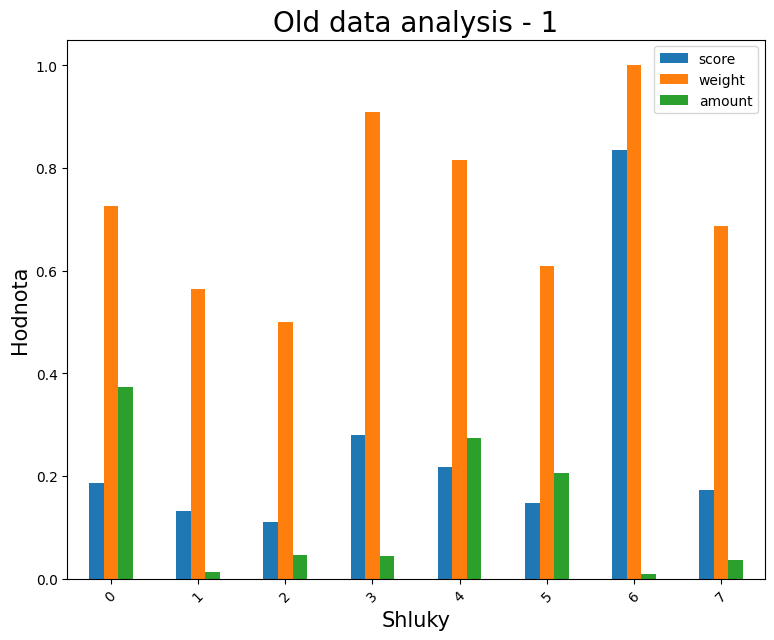

POTENTIAL AMOUNT 165521
REDUCED AMOUNT 114437
Extracted data 1  -  114436
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
kmeans Model Build progress: |███████████████████████████████████████████████████| (done) 100%
kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%
ModelMetricsClustering: kmeans
** Reported on train data. **

Total Within Cluster Sum of Square Error: 10420008.735547498
Total Sum of Square Error to Grand Mean: 19663401.9925754
Between Cluster Sum of Square Error: 9243393.257027902

Centroid Statistics: 
    centroid    size    within_cluster_sum_of_squares
--  ----------  ------  -------------------------------
    1           728339  8.07196e+06
    2           123777  1.11211e+06
    3           14483   572688
    4           27134   288614
    5           50      163302
    6           2       49618.3
    7           3       17617.7
    8           2       144098
    9       

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


█████████████████████████████████████████████████████████| (done) 100%
kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%
ModelMetricsClustering: kmeans
** Reported on train data. **

Total Within Cluster Sum of Square Error: 21332062.76281155
Total Sum of Square Error to Grand Mean: 29755924.043592773
Between Cluster Sum of Square Error: 8423861.280781224

Centroid Statistics: 
    centroid    size         within_cluster_sum_of_squares
--  ----------  -----------  -------------------------------
    1           1.05602e+06  1.44824e+07
    2           103          1.8263e+06
    3           248414       3.21816e+06
    4           46554        1.17954e+06
    5           1456         625633
█

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


TOTAL ACC 0.9400855457260142


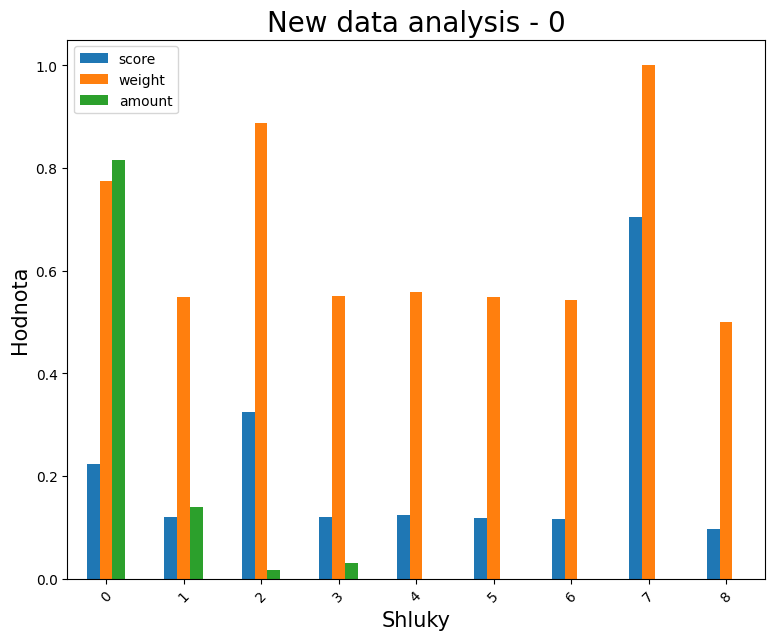

POTENTIAL AMOUNT 660452
REDUCED AMOUNT 283424
█Extracted data 0  -  283424
█████| (done) 100%
kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%
ModelMetricsClustering: kmeans
** Reported on train data. **

Total Within Cluster Sum of Square Error: 13377648.903644409
Total Sum of Square Error to Grand Mean: 25567608.00746226
Between Cluster Sum of Square Error: 12189959.10381785

Centroid Statistics: 
    centroid    size    within_cluster_sum_of_squares
--  ----------  ------  -------------------------------
    1           614361  5.82141e+06
    2           114702  526793
    3           197086  1.43814e+06
    4           192013  1.81734e+06
    5           28459   2.51649e+06
    6           12668   626277
    7           2638    366475
    8           237     264722


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


TOTAL ACC 0.9867501341917663


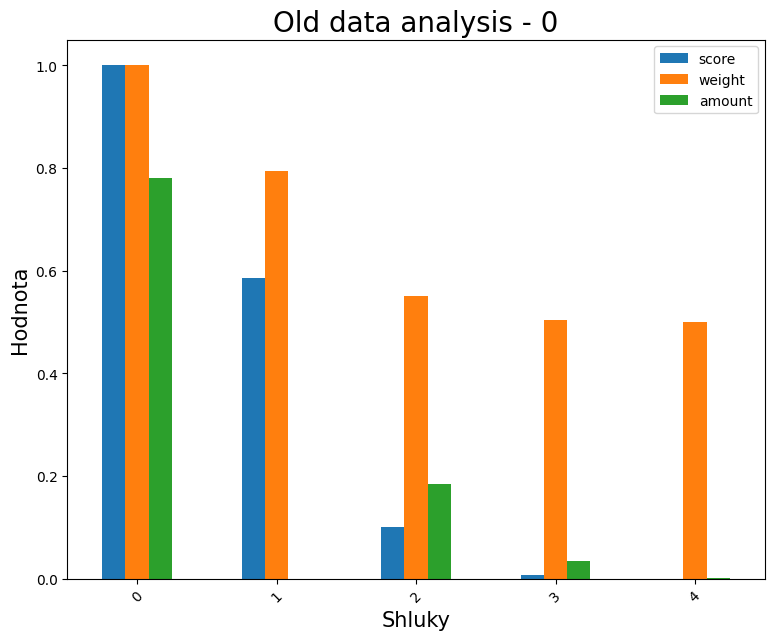

POTENTIAL AMOUNT 1217073
REDUCED AMOUNT 270020
Extracted data 0  -  270020


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


TOTAL ACC 0.23153358734223398


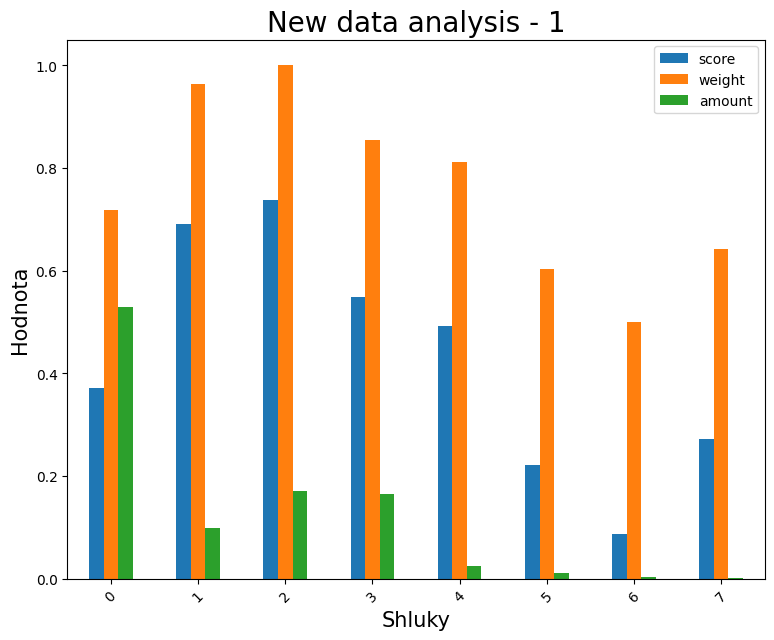

POTENTIAL AMOUNT 945332
REDUCED AMOUNT 439007
Extracted data 1  -  439009
CPU times: user 1.88 s, sys: 3.54 s, total: 5.42 s
Wall time: 2min 40s
Old dataset balance {0: 1352542, 1: 228729, 'all': 1581271}


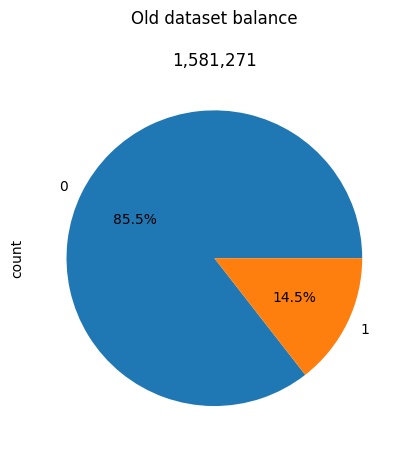

Clustered dataset balance {0: 553444, 1: 553445, 'all': 1106889}


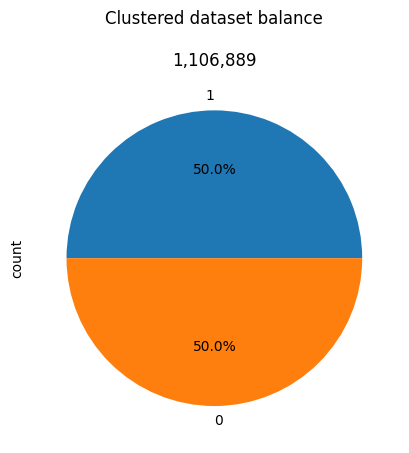

Reduction ratio 30.000044268186798


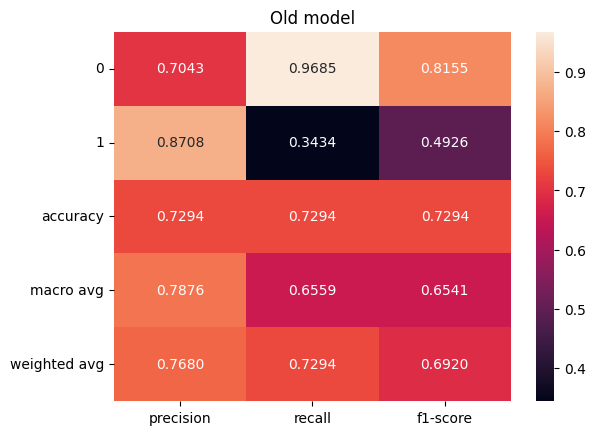

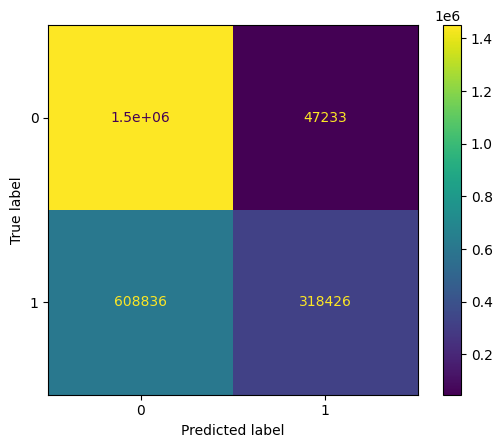

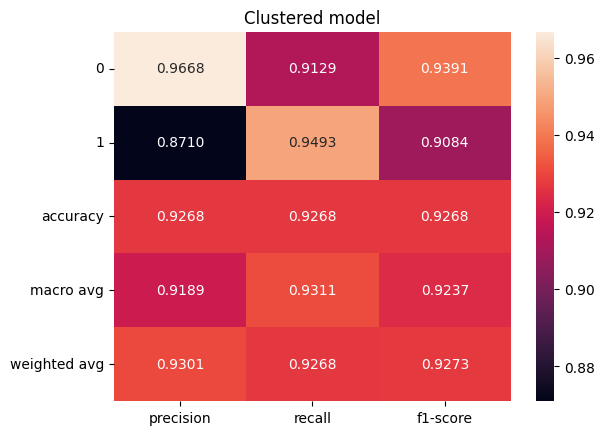

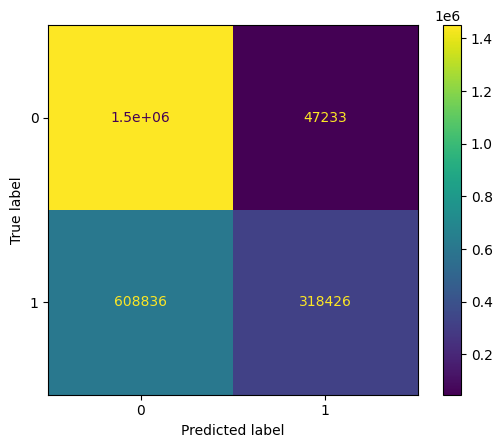

Improvement 76.40916487176185
H2O session _sid_8ff0 closed.


In [73]:
# Choose modification and K estimation method 
for alg in ['h2o']:#kmeans
    print(alg)
    if alg== 'h2o':
        k_methods=['default']
        h2o.init()
    else:
        k_methods=['calinski_harabasz','bouldin','PRE','elbow']#,'calinski_harabasz','silhouette','elbow','bouldin','PRE']:
    for metric in k_methods:
        print(metric)
        for red in [0.7]:#[0.8,0.7,0.6,0.5,0.4]:#0.3,0.2,0.1,0.05
        
            input_vector,jobs,reduction=get_params(red)
            %time results=Parallel(n_jobs=jobs,backend="multiprocessing")([delayed(modification_one)(label=i[0],data=i[1],clf=i[2],undersample=i[3],metric=metric,alg=alg,desc=i[4]) for i in input_vector])
            
            old_data.newdata=pd.concat(results)
            #print(old_data.newdata)

            clustered_result=old_data.compare_models(clfs['old'],clfs['clustered'],test_data)
            tmp=old_data.prepare_model_result(clustered_result,text+" "+str(reduction),use_case,alg+'_'+metric)
            framework_result=pd.concat([framework_result,tmp])

            #old_data.save_new(output_directory+use_case+"_new_data_"+alg+"_"+metric+"_"+str(reduction)+".csv")
            
    if alg == 'h2o':
        h2o.cluster().shutdown()

#### Show results

In [74]:
# Print results
framework_result

,Dataset,Method,Metric,Acc,Precision,Recall,F1,Impr,Support_0,Support_1
0,DOH,merging,old,0.729436,0.767998,0.729436,0.692035,0.000000,1352542,228729
0,DOH,merging,new,0.852488,0.866056,0.852488,0.854321,0.000000,1352542,228729
0,DOH,merging 0.7,h2o_default,0.929704,0.932155,0.929704,0.930140,77.315770,553444,553445
0,DOH,merging 0.7,h2o_default,0.926822,0.930117,0.926822,0.927348,76.409165,553444,553445


In [66]:
# Save results
framework_result.to_csv(f"{output_directory}{use_case}_{text}_result.csv",mode='a',index=False)

# Comparation

Old data analysis - 0 To be extracted -  270020
Old data analysis - 1 To be extracted -  114437
New data analysis - 0 To be extracted -  283424
New data analysis - 1 To be extracted -  439007
{0: 553444, 1: 553444}
random sampler
CPU times: user 3.15 s, sys: 1.48 s, total: 4.64 s
Wall time: 4.67 s
Old dataset balance {0: 2246333, 1: 1390893, 'all': 3637226}


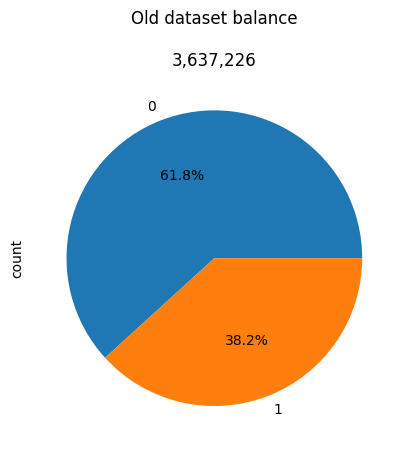

random sampler dataset balance {0: 553444, 1: 553444, 'all': 1106888}


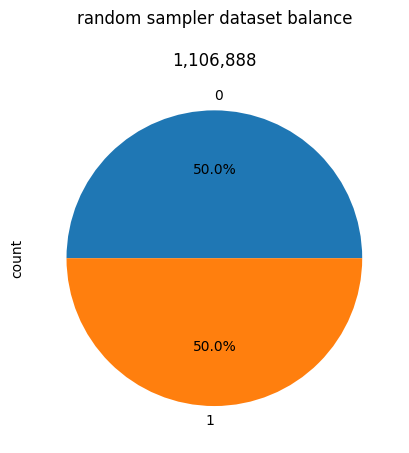

Reduction ratio 69.56779699694218


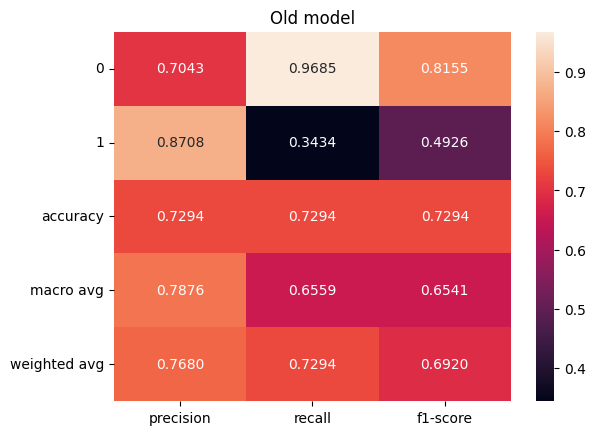

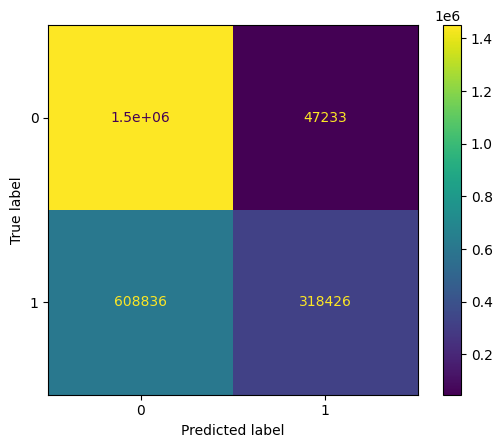

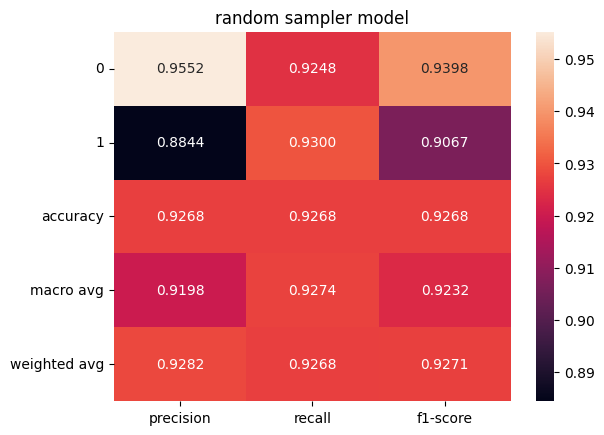

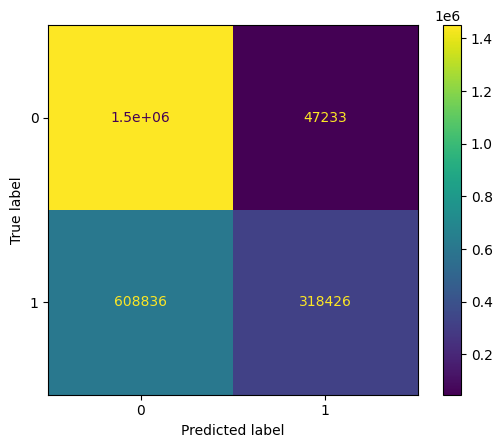

Improvement 76.32632059322863


,Dataset,Method,Metric,Acc,Precision,Recall,F1,Impr,Support_0,Support_1
0,DOH,merging,old,0.729436,0.767998,0.729436,0.692035,0.000000,1352542,228729
0,DOH,merging,new,0.852488,0.866056,0.852488,0.854321,0.000000,1352542,228729
0,DOH,merging 0.7,h2o_default,0.938132,0.939977,0.938132,0.938468,80.019865,553444,553445
0,DOH,merging 0.7,h2o_default,0.938132,0.939977,0.938132,0.938468,80.019865,553444,553445
0,DOH,merging 0.7,h2o_default,0.938132,0.939977,0.938132,0.938468,80.019865,553444,553445
0,DOH,merging 0.7,h2o_default,0.936845,0.939268,0.936845,0.937241,79.621410,553444,553445
0,DOH,random sampler 0.7,random sampler,0.926767,0.928161,0.926767,0.927093,76.326321,553444,553444


In [67]:
# Comaration with imbalanced learn library which implements various methods of data modification
for reduction in [0.7]:#,0.7,0.6,0.5,0.4]:#[1,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05]:
  vec,_,red=get_params(reduction)
  if merging:
    balance_dict={0:vec[0][3]+vec[2][3],1:vec[1][3]+vec[3][3]}
  else:
    balance_dict={0:vec[0][3],1:vec[1][3]}
  print(balance_dict)
  imbl=[#(NearMiss(sampling_strategy=balance_dict,version=1,n_jobs=-1),"near miss1"),###########
        #(NearMiss(sampling_strategy=balance_dict,version=2,n_jobs=-1),"near miss2"),############
        #(NearMiss(sampling_strategy=balance_dict,version=3,n_jobs=-1),"near miss3"),
        #(CondensedNearestNeighbour(random_state=42,sampling_strategy='all',n_jobs=-1),"condensed_NN"),
        #(EditedNearestNeighbours(),"edited_NN"),
        #(RepeatedEditedNearestNeighbours(sampling_strategy='all',n_jobs=-1),"rep_edited__NN"),
        #(InstanceHardnessThreshold(sampling_strategy=balance_dict,random_state=42, estimator=LogisticRegression(solver='lbfgs', max_iter=200)),"inst_hard_tresh"),########
        #(NeighbourhoodCleaningRule(sampling_strategy='all',n_jobs=-1),"neigh_clean_rule"),
        #(OneSidedSelection(sampling_strategy='all',n_jobs=-1,random_state=42),"one_sided_sel"),
        (RandomUnderSampler(sampling_strategy=balance_dict),"random sampler"),#ranmagic random_state=1
        #(TomekLinks(sampling_strategy='all',n_jobs=-1),"tomek_links"),
        #(AllKNN(sampling_strategy='all',n_jobs=-1),"allKNN"),
        #(ClusterCentroids(sampling_strategy=balance_dict,n_jobs=-1),"cluster centroids"),#########
        #(ClusterCentroids(sampling_strategy=balance_dict,random_state=42,estimator=KMeans(n_clusters=cluster_model.size)),"cluster_centroids_est_k")
        ]

  if merging:
    backup=old_data.csv_data
    old_data.csv_data=pd.concat([old_data.csv_data,new_data.csv_data],axis=0)
  for sampler in imbl:
    print(sampler[1])
    %time old_data.apply_imbalanced_lib(sampler[0])
    imbl_result=old_data.compare_models(clfs['old'],clfs['compare'],test_data,sampler[1])
    tmp=old_data.prepare_model_result(imbl_result,sampler[1]+" "+str(red),use_case,sampler[1])
    framework_result=pd.concat([framework_result,tmp])

  if merging:
    old_data.csv_data=backup
framework_result